<a href="https://colab.research.google.com/github/mzijewel/MachineLearning/blob/master/tree/master/Supervised/Classifcation/Cifar10PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.mobile_optimizer import optimize_for_mobile

import torch.nn as nn
import torch.nn.functional as F


import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:06<00:00, 24829629.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


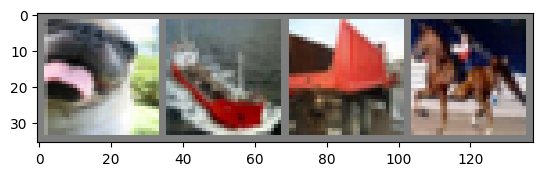

dog   ship  truck horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
model = Model().to(device)

In [26]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
# loss: 1.266 (ep2)

[1,  2000] loss: 2.225
[1,  4000] loss: 1.851
[1,  6000] loss: 1.692
[1,  8000] loss: 1.623
[1, 10000] loss: 1.535
[1, 12000] loss: 1.499
[2,  2000] loss: 1.427
[2,  4000] loss: 1.391
[2,  6000] loss: 1.353
[2,  8000] loss: 1.333
[2, 10000] loss: 1.305
[2, 12000] loss: 1.266
Finished Training


In [12]:
def save_weight(path):
  torch.save(model.state_dict(), path)

In [13]:
save_weight('m.pth')

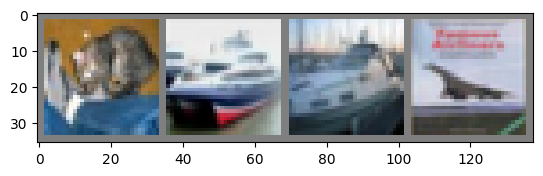

GroundTruth:  cat   ship  ship  plane


In [14]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [15]:
def load_weight(path):
  model = Model()
  model.load_state_dict(torch.load(path))
  return model

In [16]:
model=load_weight('m.pth')
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


In [19]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.1 %
Accuracy for class: car   is 65.2 %
Accuracy for class: bird  is 41.9 %
Accuracy for class: cat   is 39.7 %
Accuracy for class: deer  is 40.4 %
Accuracy for class: dog   is 24.4 %
Accuracy for class: frog  is 86.0 %
Accuracy for class: horse is 61.2 %
Accuracy for class: ship  is 62.4 %
Accuracy for class: truck is 56.5 %


In [29]:
def predict(model,img_path):
  with torch.no_grad():
    img=Image.open(img_path).resize((32,32))
    # img_tns=torchvision.transforms.ToTensor()(img).unsqueeze(0)
    img_tns=transform(img).unsqueeze(0)
    result=model(img_tns)
    probabilities=torch.softmax(result[0],dim=0)
    # max_indx=torch.argmax(probabilities)
    max_val,max_indx=torch.max(probabilities,dim=0)
    item=classes[max_indx]
    print(f'{item} : {max_val*100:0.2f}% : index {max_indx}')

In [21]:
images[0].shape

torch.Size([3, 32, 32])

In [22]:
def save_model():
  model.eval()
  input=torch.randn(1,3,32,32)
  m=torch.jit.trace(model.to(torch.device('cpu')),input)
  torch.jit.save(m,'mc.pt')
  # s=optimize_for_mobile(m)
  # s._save_for_lite_interpreter('m10.ptl') # this prediction is not correct

In [23]:
def load_model(path):
  model=torch.jit.load(path)
  model.eval()
  # count=sum(p.numel() for p in model.parameters())
  # print(f"prams: {count}")
  return model

In [30]:
model=load_weight('/content/m.pth')

In [31]:
predict(model,'/content/cat.jpg')

cat : 39.11% : index 3
